# Задача

![задание](picture.png)

Технологии искусственного интеллекта трансформируют сферу управления персоналом, позволяя решать практические HR-задачи. Уже сейчас умные алгоритмы могут подобрать кадры, спланировать размер фонда заработной платы, выбрать образовательные курсы, оценить мотивацию, эффективность труда и даже спрогнозировать карьерное развитие специалиста.

Аналитика по определению карьерной траектории строится, в том числе, на основе данных по использованию различных корпоративных информационных систем (система мониторинга рабочего времени, сервисы видеоконференции связи, IP-телефонии, СЭД, СКУД, электронная почта). Таким образом, для некоторых профессий, связанных с активным использованием электронных устройств (программист, бухгалтер, маркетолог и т.д.), можно выделить цифровой профиль успешных специалистов, выполняющих задачи своевременно и качественно и получающих новые должности.

На основе совокупности информации о кадровых назначениях, активности и вовлеченности сотрудников в производственный процесс, участникам чемпионата нужно предложить алгоритм по прогнозу изменений должности работников.

## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
import warnings
import numpy as np
warnings.filterwarnings('ignore')


В начале остановимся на наиболее перспективных навыках

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_calls = pd.read_csv("Calls.csv")
df_connection_time = pd.read_csv("ConnectionTime.csv")
df_ed = pd.read_csv("Education.csv")
df_tasks=pd.read_csv('Tasks.csv')
timennetwork=pd.read_csv('TimenNetwork.csv')
workingday=pd.read_csv("WorkingDay.csv")

In [3]:
df_train['type'].value_counts()

2    298
0    153
1     74
3     25
Name: type, dtype: int64

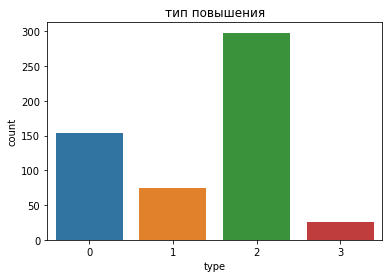

In [4]:
sns.countplot(x = "type" , data  = df_train).set_title('тип повышения')
plt.show()

## Рассмотрим датасет по ближе

In [5]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [6]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [7]:
df_connection_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   dateNum                           230662 non-null  object
 1   maxLogOff                         230662 non-null  object
 2   Нормативное время начала раб.дня  230662 non-null  object
 3   Фактич. время начала раб.дня      230662 non-null  object
 4   Время опоздания                   103101 non-null  object
 5   Признак опоздания                 77520 non-null   object
 6   Вых/Будни                         230662 non-null  object
 7   id                                230662 non-null  object
dtypes: object(8)
memory usage: 14.1+ MB


In [8]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


Узнаем размерность наборов

In [9]:
print("df_train", df_train.shape)
print("df_calls", df_calls.shape)
print("df_connection_time", df_connection_time.shape)
print("df_ed", df_ed.shape)
print("df_test", df_test.shape)

df_train (550, 2)
df_calls (407867, 6)
df_connection_time (230662, 8)
df_ed (5609, 4)
df_test (262, 2)


### Видоизмение данных

Обьединим два набора с данными

In [10]:
df_train = pd.merge(df_train, df_ed , on="id", how='left').drop_duplicates(subset="id")

df_train.head(3)

,id,type,Табельный номер руководителя,Вид образования,Специальность
0,ОРГ1-02050,2,NaN,Неполное высшее образование,Технологические машины и оборудование
2,ОРГ1-02783,2,ОРГ1-01974,Высшее образование,Автоматизация технологических процессов и прои...
3,ОРГ2-06173,0,ОРГ2-01170,Высшее образование,Управление качеством


In [11]:
df_train = df_train.drop(["Табельный номер руководителя", "Специальность"],axis = 1)
df_train["Вид образования"].value_counts()

Высшее образование                                297
Среднее профессиональное образование               64
Высшее образование - бакалавриат                   59
Высшее образование - специалитет, магистратура     30
Начальное профессиональное образование              7
Повышение квалификации                              7
Неполное высшее образование                         5
Среднее общее образование                           3
Среднее (полное) общее образование                  2
Переподготовка                                      2
Профессиональное обучение                           1
Name: Вид образования, dtype: int64

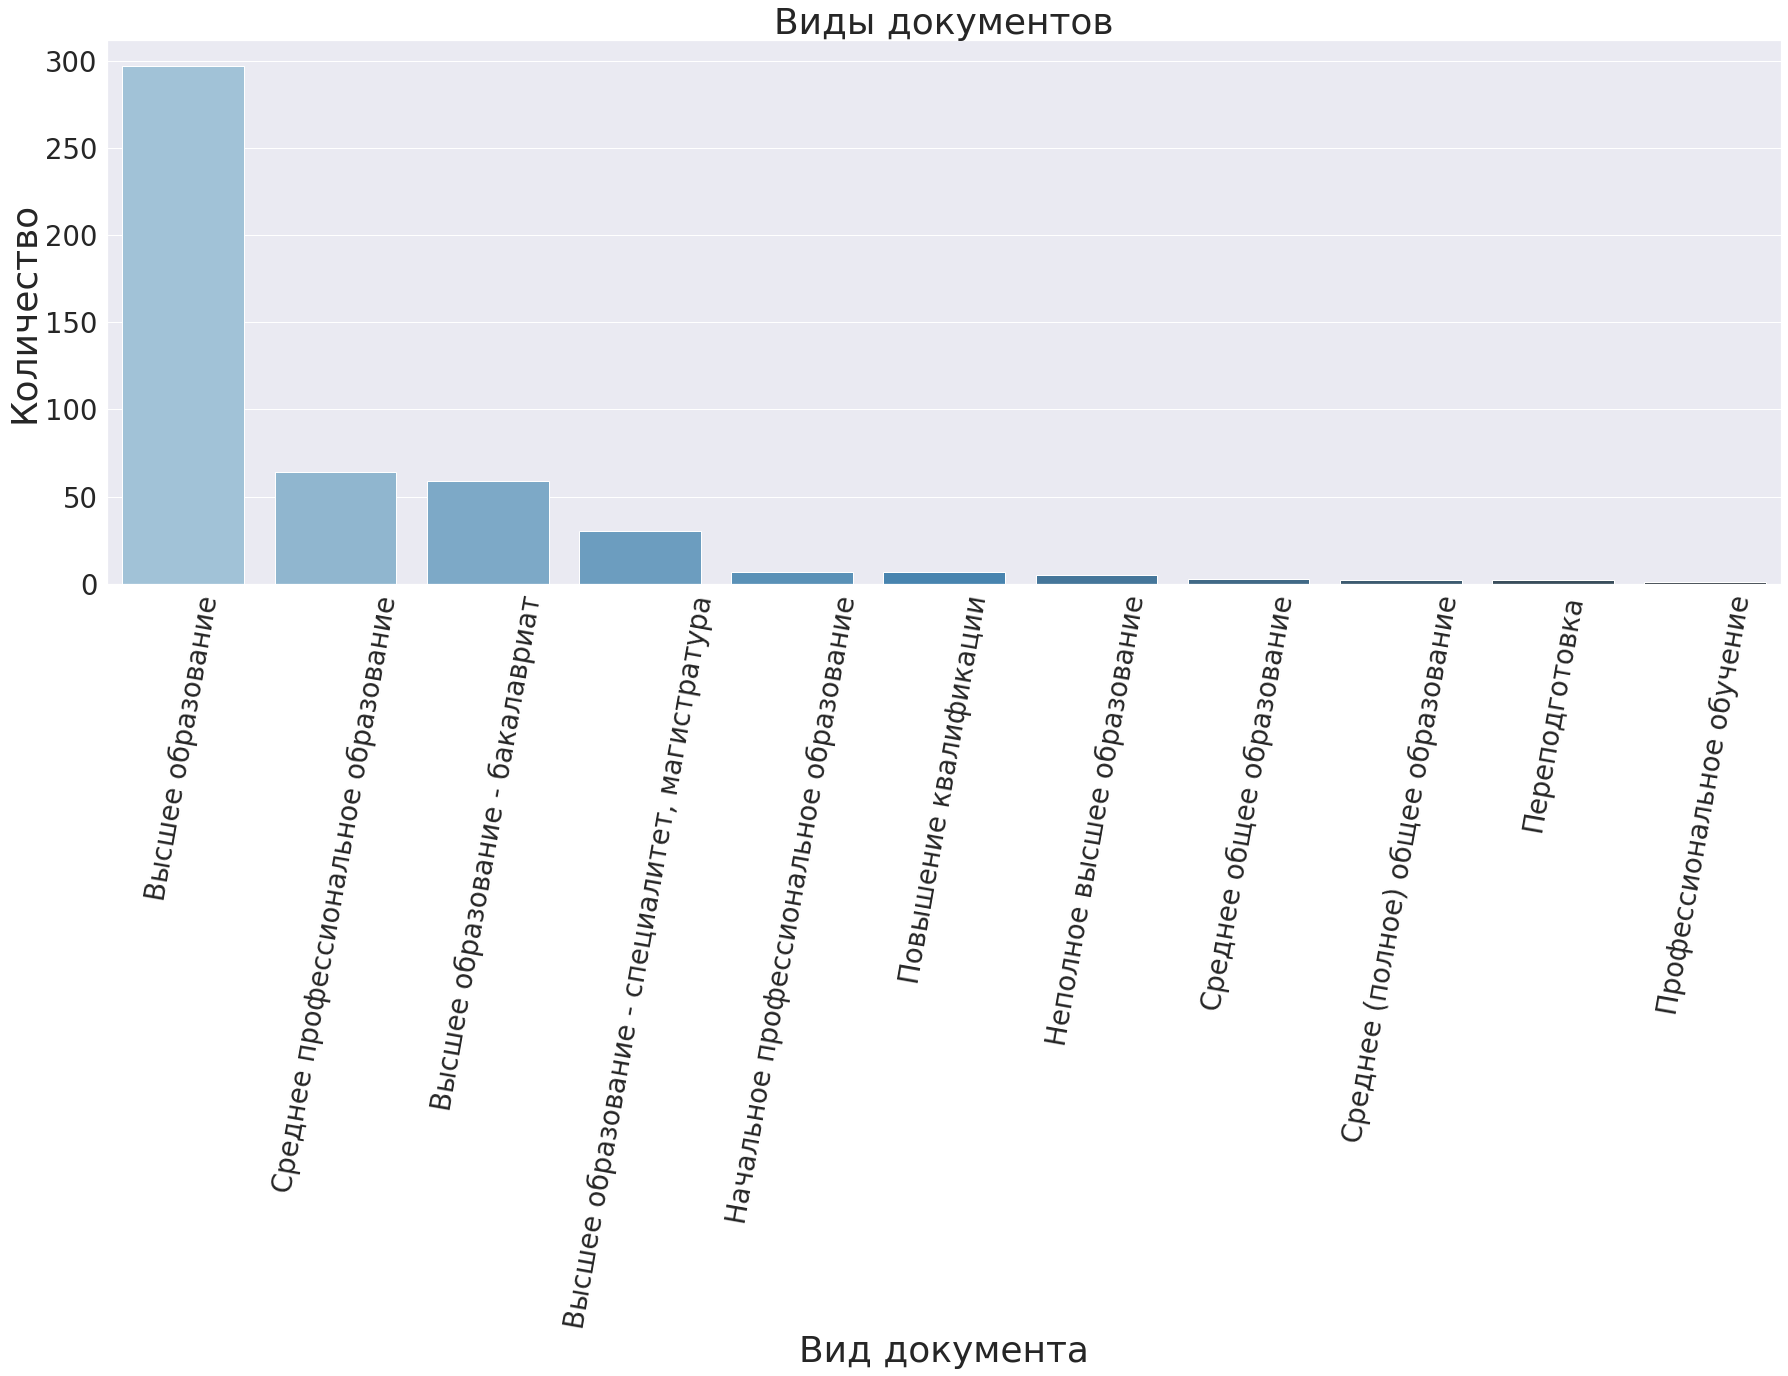

In [12]:
edu_type=pd.DataFrame(df_train["Вид образования"].value_counts()).reset_index()
plt.figure(figsize=(30,10))
sns.set_context("paper", font_scale=2)
sns.set_theme(style="whitegrid")
sns.set(font_scale=2.5)
sns.barplot(x=edu_type['index'],y=edu_type['Вид образования'],data=edu_type, palette="Blues_d") 
plt.title('Виды документов', size=36)
plt.xlabel('Вид документа', size=36)
plt.ylabel('Количество', size=36)
plt.xticks(rotation=80)
plt.show()

In [13]:
df_train["Вид образования"] = df_train["Вид образования"].astype('category')
df_train["Вид образования"] = df_train["Вид образования"].cat.codes

Оставим только столбец - опоздания сотрудников

In [14]:
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]

df_connection_time_res.head()

,id,Признак опоздания
127561,ОРГ1-01589,Опоздание
127562,ОРГ1-01589,Опоздание
127563,ОРГ1-01589,Опоздание
127564,ОРГ1-01589,Опоздание
127565,ОРГ1-01589,Опоздание


In [15]:
df_connection_time_res = df_connection_time_res.groupby("id").count()
df_connection_time_res = df_connection_time_res.rename(columns={"Признак опоздания": "Число опозданий"})
df_connection_time_res.head(3)

,Число опозданий
id,
ОРГ1-00004,275
ОРГ1-00028,35
ОРГ1-00030,57


In [16]:
df_train = pd.merge(df_train, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

df_train.head(3)

,id,type,Вид образования,Число опозданий
0,ОРГ1-02050,2,4,5.0
1,ОРГ1-02783,2,0,7.0
2,ОРГ2-06173,0,0,22.0


## Добавим суммарное время звонков!



In [17]:
def str_to_float(str):
    if type(str)==float:
        return str
    str=str.replace(',','')
    return float(str)

df_calls['CallTime']=df_calls['CallTime'].map(str_to_float)
CallTime=pd.DataFrame(df_calls.groupby('id')['CallTime'].sum()).reset_index()
df_train = pd.merge(df_train, CallTime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime
0,ОРГ1-02050,2,4,5.0,4.810983e+18
1,ОРГ1-02783,2,0,7.0,1.350599e+19
2,ОРГ2-06173,0,0,22.0,NaN
3,ОРГ2-05359,2,10,6.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17
...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19
547,ОРГ1-02862,2,-1,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19


## Добавим колличество звонков в будни и выходные

In [18]:
NumberOfCalls=pd.DataFrame(df_calls.groupby('id')['NumberOfCalls'].sum()).reset_index()
df_calls= df_calls.rename(columns={'Вид учета времени': 'statusworkfre'})

NumberOfCallsW=pd.DataFrame(df_calls.query("statusworkfre=='Будни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberOfCallsNW=pd.DataFrame(df_calls.query("statusworkfre=='Выходные дни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
df_train = pd.merge(df_train, NumberOfCalls , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsW , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsNW , on="id", how='left')
df_train = df_train.rename(columns={'NumberOfCalls_x': 'NumberOfCalls_worck','NumberOfCalls_y': 'NumberOfCalls_free','NumberOfCalls': 'NumberOfCallsfreesum'})
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN
...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0


## Добавим колличество входящих и исходящих.

In [19]:
NumberToUser=pd.DataFrame(df_calls.query("InOut=='ToUser'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberFromUser=pd.DataFrame(df_calls.query("InOut=='FromUser'").groupby('id')['NumberOfCalls'].sum()).reset_index() 
df_train = pd.merge(df_train, NumberToUser , on="id", how='left')
df_train = pd.merge(df_train, NumberFromUser , on="id", how='left')

## Добавим суммарное время опазданий

In [20]:
df_connection_time['Время опоздания']=df_connection_time['Время опоздания'].map(str_to_float)
falout=pd.DataFrame(df_connection_time.groupby('id')['Время опоздания'].sum()).reset_index() 
df_train = pd.merge(df_train, falout , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17
...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17


## Добавим дельту прихода на работу

In [21]:
df_connection_time['Нормативное время начала раб.дня']=pd.to_datetime(df_connection_time['Нормативное время начала раб.дня'])
df_connection_time['Фактич. время начала раб.дня']=pd.to_datetime(df_connection_time['Фактич. время начала раб.дня'])
df_connection_time['filtime']=df_connection_time['Нормативное время начала раб.дня']-df_connection_time['Фактич. время начала раб.дня']
filtime=pd.DataFrame(df_connection_time.groupby('id')['filtime'].mean().dt.total_seconds()).reset_index()
df_train = pd.merge(df_train, filtime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892
...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964


## Добавим Профессию

In [22]:
prof=pd.DataFrame(df_ed['Специальность'].value_counts()).reset_index()
profhed=prof.head(457)
profhed['profcod']=profhed.index
proftail=prof.tail(623)
proftail['profcod']=999
profhed=profhed.append(proftail)
profhed= profhed.rename(columns={'index': 'specialisation'})
uniq = profhed['specialisation'].values
fifa = profhed['profcod'].values
uniq_and_fifa = dict(zip(uniq, fifa))
uniq_and_fifa
df_ed['Специальность']=df_ed['Специальность'].map(uniq_and_fifa)
professionstart=df_ed[['id','Специальность']].groupby('id')['Специальность'].min()
professionend=df_ed[['id','Специальность']].groupby('id')['Специальность'].max()
df_train = pd.merge(df_train, professionstart , on="id", how='left')
df_train = pd.merge(df_train, professionend , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0


## Добавим rколичество  руководителей

In [23]:
df_ed

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,6.0
1,NaN,ОРГ1-03220,Среднее профессиональное образование,135.0
2,NaN,ОРГ1-03008,Высшее образование,6.0
3,NaN,ОРГ1-00922,Высшее образование - бакалавриат,999.0
4,NaN,ОРГ1-00922,Высшее образование,35.0
...,...,...,...,...
5604,ОРГ2-09100,ОРГ2-08601,Начальное профессиональное образование,55.0
5605,ОРГ2-09100,ОРГ2-08622,Начальное профессиональное образование,NaN
5606,ОРГ2-09100,ОРГ2-04773,Среднее профессиональное образование,275.0
5607,ОРГ2-09100,ОРГ2-05048,"Высшее образование - специалитет, магистратура",257.0


In [24]:
boss=df_ed.groupby('id')['Табельный номер руководителя'].count()

In [25]:
df_train = pd.merge(df_train, boss , on="id", how='left')

# Добавим колличество завершенных заданий

In [26]:
documents_type=pd.DataFrame(df_tasks['Вид документа'].value_counts()).reset_index()

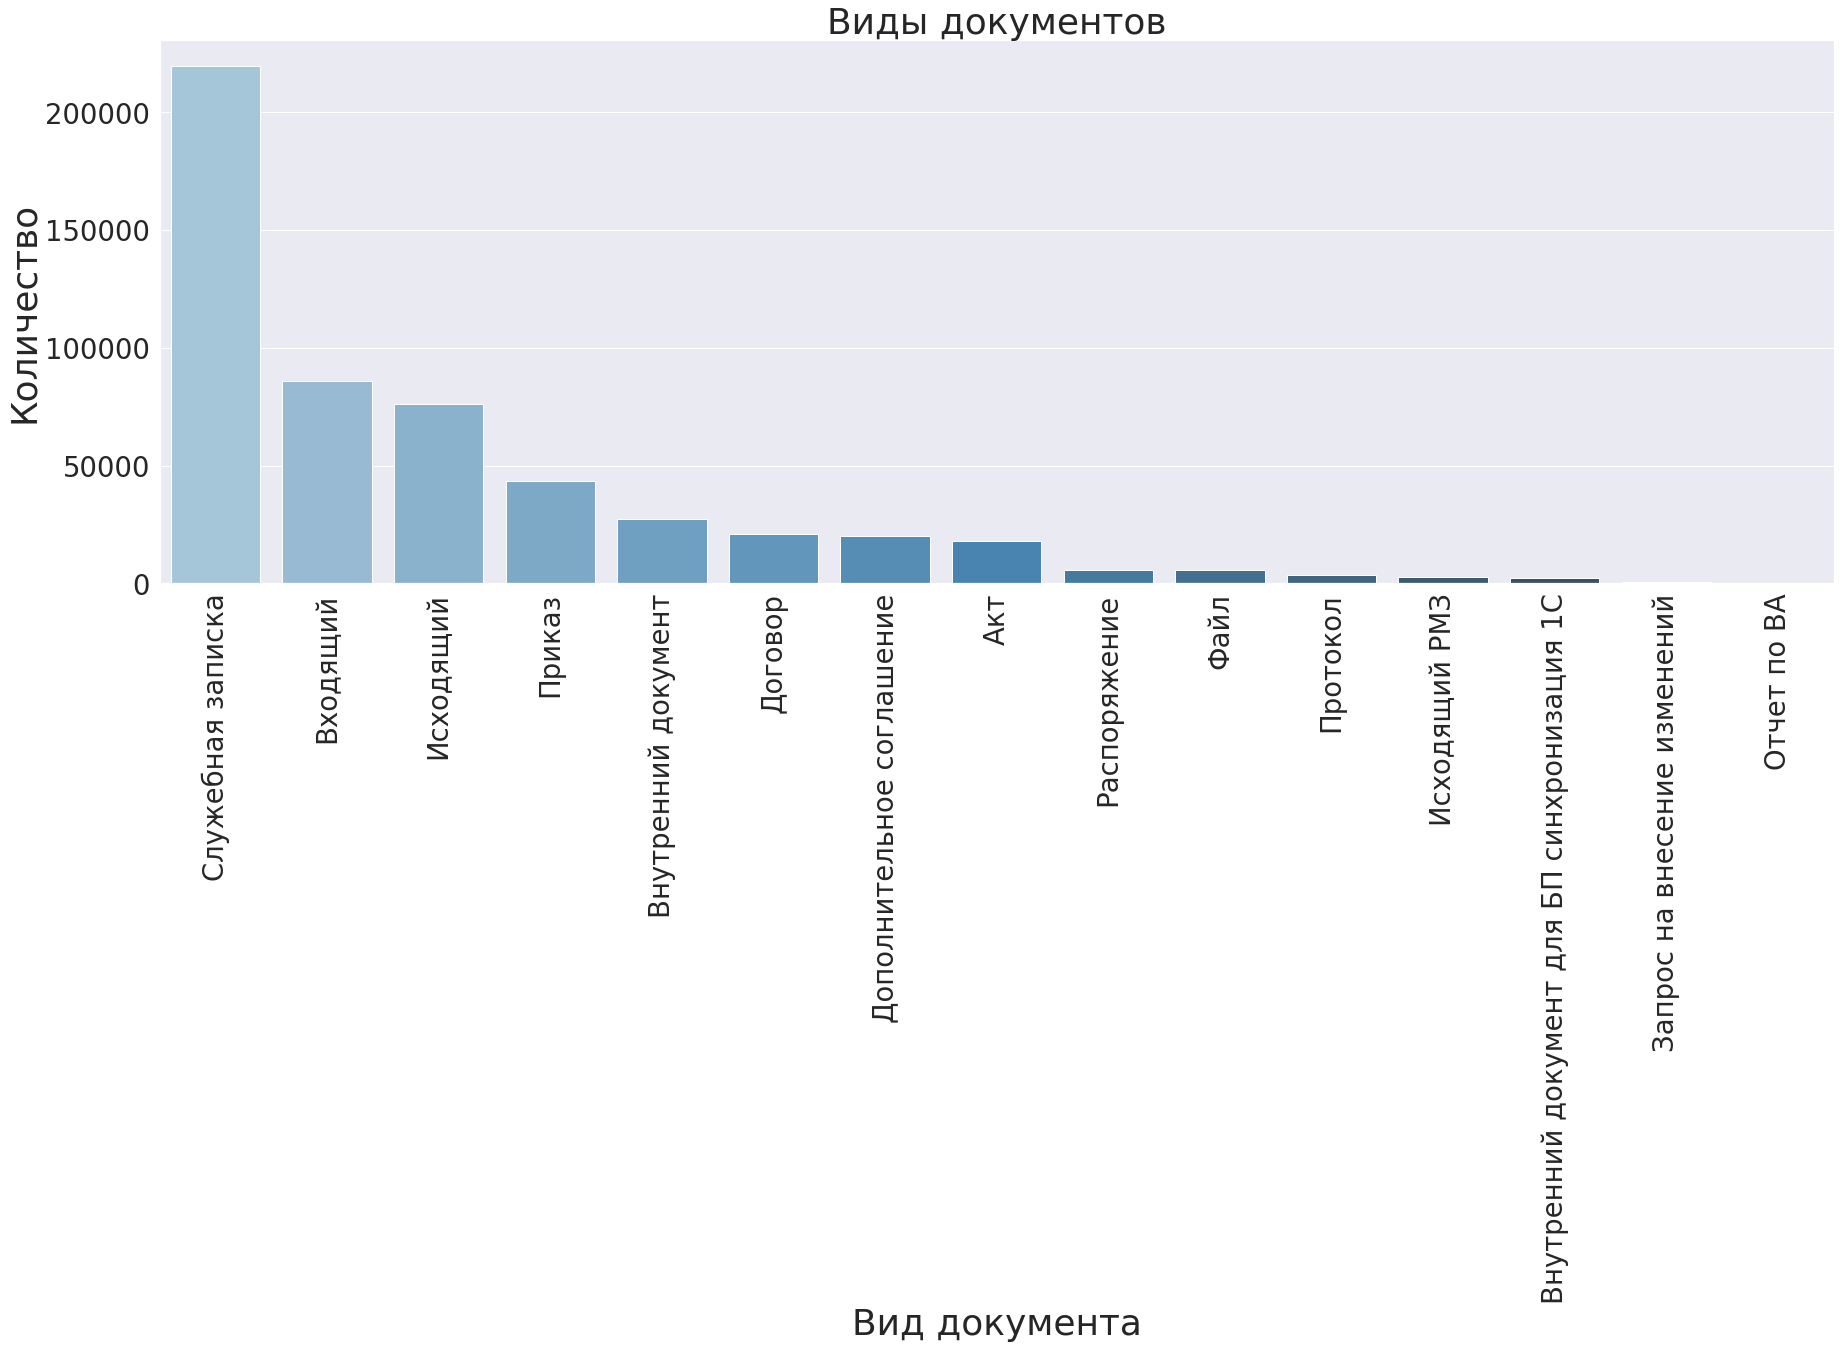

In [27]:
plt.figure(figsize=(30,10))
sns.set_context("paper", font_scale=2)
sns.set_theme(style="whitegrid")
sns.set(font_scale=2.5)
sns.barplot(x=documents_type['index'],y=documents_type['Вид документа'],data=documents_type, palette="Blues_d") 
plt.title('Виды документов', size=36)
plt.xlabel('Вид документа', size=36)
plt.ylabel('Количество', size=36)
plt.xticks(rotation=90)
plt.show()

In [28]:
df_tasks.head(50)

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
5,Без нарушения срока,NaN,0,без нарушения срока,F229CA53-B362-42D7-8B35-F969EB14F421,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
6,Без нарушения срока,NaN,0,без нарушения срока,BE9F1F9E-B665-4306-AAFA-38980940C6BF,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
7,Без нарушения срока,NaN,0,без нарушения срока,D805905B-7176-44DA-9BE4-413C87396AE6,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
8,Без нарушения срока,NaN,0,без нарушения срока,AF0D0B62-EA68-489A-8710-3025BECBE93B,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
9,Без нарушения срока,NaN,0,без нарушения срока,5B267180-9C99-4326-9A2C-F0E5ECC12C7C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588


In [29]:
df_tasks['2']=str(df_tasks['ID задачи'])
df_tasks    

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id,2
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
...,...,...,...,...,...,...,...,...,...,...,...,...
536655,Без нарушения срока,NaN,0,без нарушения срока,9FE7B014-3015-4855-BD08-D3C5260FB122,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
536656,Без нарушения срока,NaN,0,без нарушения срока,B4A7AE02-2D7E-4D56-A337-0F14C27A85CC,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
536657,Без нарушения срока,NaN,0,без нарушения срока,698F3F66-37BA-4042-BDE9-5F8C8BEA7FA6,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...
536658,Без нарушения срока,NaN,0,без нарушения срока,A7D0F2FA-9C2A-4F4D-A990-ABE463A5F0D5,Служебная записка,"2021-10-30 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...


In [30]:
df_tasks['Статус по просрочке'].value_counts()
temp_type=pd.DataFrame(df_tasks['Статус по просрочке'].value_counts()).reset_index()

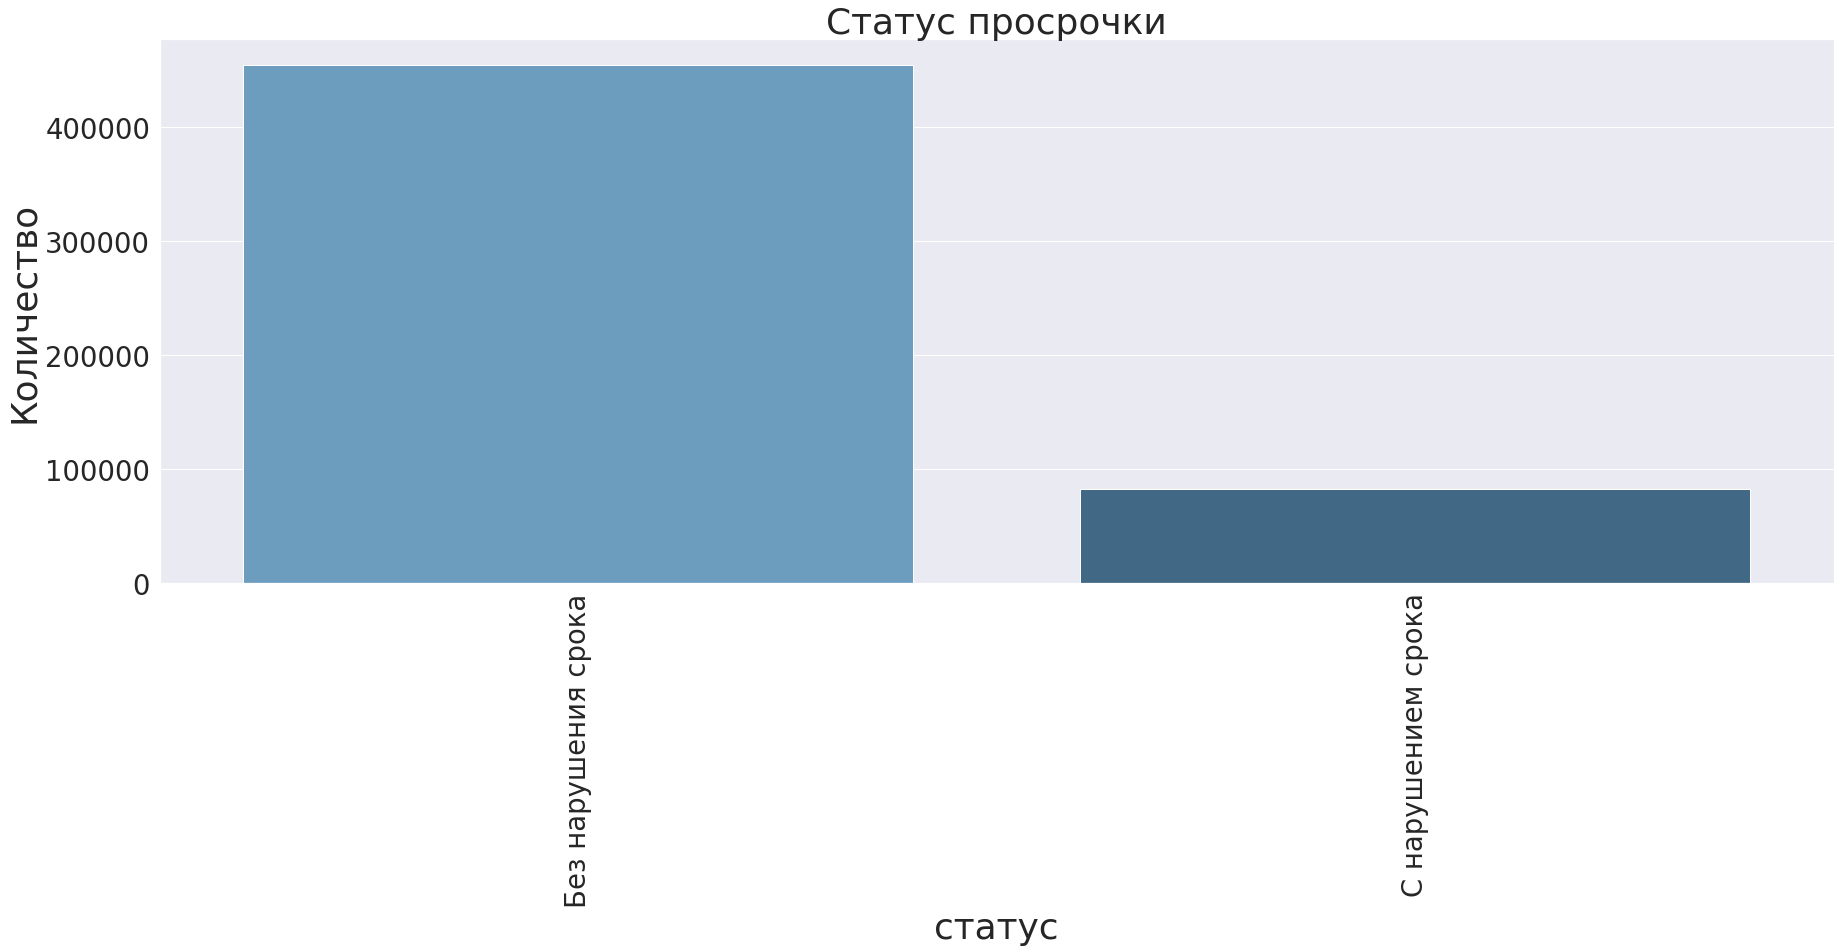

In [31]:
plt.figure(figsize=(30,10))
sns.set_context("paper", font_scale=2)
sns.set_theme(style="whitegrid")
sns.set(font_scale=2.5)
sns.barplot(x=temp_type['index'],y=temp_type['Статус по просрочке'],data=temp_type, palette="Blues_d") 
plt.title('Статус просрочки', size=36)
plt.xlabel('статус', size=36)
plt.ylabel('Количество', size=36)
plt.xticks(rotation=90)
plt.show()

In [32]:
df_tasks = df_tasks.rename(columns={'Состояние задания': 'status_mission_count','Статус по просрочке':'статус_просрочек'})
status_mission_count=pd.DataFrame(df_tasks.query("status_mission_count=='Завершено'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'завершено'})
df_train = pd.merge(df_train,status_mission_count, on="id", how='left')

# Добавим колличество заданий в работе.

In [33]:
status_mission_count_in=pd.DataFrame(df_tasks.query("status_mission_count=='В работе'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'вработе'})
df_train = pd.merge(df_train,status_mission_count_in, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y,Табельный номер руководителя,завершено,вработе
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0,0.0,1.0,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0,1.0,306.0,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0,1.0,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0,1.0,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0,0.0,155.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0,0.0,102.0,3.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0,0.0,33.0,NaN


In [34]:
df_tasks['status_mission_count'].value_counts()

Завершено                  520779
Не начато                    7842
В работе                     7571
Делегировано                  344
На приёмке                     60
Отложено                       55
Возврат с делегирования         9
Name: status_mission_count, dtype: int64

# Добавим задания в работе по месяцам.

In [35]:
df_tasks['monthstart']=pd.to_datetime(df_tasks['Дата старта задания']).dt.month
for i in range(1,13):
    tasks_month_sum_start=pd.DataFrame(df_tasks.query("status_mission_count=='В работе'").query('monthstart==@i').groupby('id')['Дата старта задания'].nunique()).rename(columns={'Дата старта задания': 'tasks_month_sum_start'+ str(i)})
    df_train = pd.merge(df_train,tasks_month_sum_start, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_start3,tasks_month_sum_start4,tasks_month_sum_start5,tasks_month_sum_start6,tasks_month_sum_start7,tasks_month_sum_start8,tasks_month_sum_start9,tasks_month_sum_start10,tasks_month_sum_start11,tasks_month_sum_start12
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавим количество заданий завершено по месяцам.

In [36]:
for i in range(1,13):
    tasks_month_sum_end=pd.DataFrame(df_tasks.query("status_mission_count=='Завершено'").query('monthstart==@i').groupby('id')['Дата старта задания'].nunique()).rename(columns={'Дата старта задания': 'tasks_month_sum_end'+ str(i)})
    df_train = pd.merge(df_train,tasks_month_sum_end, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_end3,tasks_month_sum_end4,tasks_month_sum_end5,tasks_month_sum_end6,tasks_month_sum_end7,tasks_month_sum_end8,tasks_month_sum_end9,tasks_month_sum_end10,tasks_month_sum_end11,tasks_month_sum_end12
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,3.0,8.0,14.0,14.0,19.0,10.0,13.0,10.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,6.0,12.0,5.0,5.0,12.0,10.0,10.0,15.0,10.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,7.0,2.0,9.0,10.0,9.0,5.0,4.0,7.0,3.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,10.0,11.0,2.0,7.0,7.0,3.0,1.0,7.0,4.0,16.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,2.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,3.0,9.0


# Добавим колличество заданий Не начато

In [37]:
status_mission_count_nn=pd.DataFrame(df_tasks.query("status_mission_count=='Не начато'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'неначато'})
df_train = pd.merge(df_train,status_mission_count_nn, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_end4,tasks_month_sum_end5,tasks_month_sum_end6,tasks_month_sum_end7,tasks_month_sum_end8,tasks_month_sum_end9,tasks_month_sum_end10,tasks_month_sum_end11,tasks_month_sum_end12,неначато
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,3.0,8.0,14.0,14.0,19.0,10.0,13.0,10.0,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,12.0,5.0,5.0,12.0,10.0,10.0,15.0,10.0,15.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,2.0,9.0,10.0,9.0,5.0,4.0,7.0,3.0,16.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,11.0,2.0,7.0,7.0,3.0,1.0,7.0,4.0,16.0,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,1.0,NaN,1.0,NaN,1.0,NaN,NaN,3.0,9.0,NaN


# Задания делегировано по месяцам

In [38]:
for i in range(1,13):
    tasks_month_sum_startn=pd.DataFrame(df_tasks.query("status_mission_count=='Делегировано'").query('monthstart==@i').groupby('id')['Дата старта задания'].nunique()).rename(columns={'Дата старта задания': 'tasks_month_sum_startn'+ str(i)})
    df_train = pd.merge(df_train,tasks_month_sum_startn, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_startn3,tasks_month_sum_startn4,tasks_month_sum_startn5,tasks_month_sum_startn6,tasks_month_sum_startn7,tasks_month_sum_startn8,tasks_month_sum_startn9,tasks_month_sum_startn10,tasks_month_sum_startn11,tasks_month_sum_startn12
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавим колличество заданий делегировано

In [39]:
status_mission_count_d=pd.DataFrame(df_tasks.query("status_mission_count=='Делегировано'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'делегировано'})
df_train = pd.merge(df_train,status_mission_count_d, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_startn4,tasks_month_sum_startn5,tasks_month_sum_startn6,tasks_month_sum_startn7,tasks_month_sum_startn8,tasks_month_sum_startn9,tasks_month_sum_startn10,tasks_month_sum_startn11,tasks_month_sum_startn12,делегировано
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавим колличество заданий На приёмке

In [40]:
status_mission_count_p=pd.DataFrame(df_tasks.query("status_mission_count=='На приёмке'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'наприемке'})
df_train = pd.merge(df_train,status_mission_count_p, on="id", how='left')
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_startn5,tasks_month_sum_startn6,tasks_month_sum_startn7,tasks_month_sum_startn8,tasks_month_sum_startn9,tasks_month_sum_startn10,tasks_month_sum_startn11,tasks_month_sum_startn12,делегировано,наприемке
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавим колличество заданий Отложено

In [41]:
status_mission_count_o=pd.DataFrame(df_tasks.query("status_mission_count=='Отложено'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'Отложено'})
df_train = pd.merge(df_train,status_mission_count_o, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_startn6,tasks_month_sum_startn7,tasks_month_sum_startn8,tasks_month_sum_startn9,tasks_month_sum_startn10,tasks_month_sum_startn11,tasks_month_sum_startn12,делегировано,наприемке,Отложено
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Добавим сумму просрочки дней!

In [42]:
day_ful_mission=pd.DataFrame(df_tasks.groupby('id')['Просрочено, дней'].sum()).reset_index().rename(columns={'Просрочено, дней': 'просрочено всего'})
df_train = pd.merge(df_train,day_ful_mission, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum_startn7,tasks_month_sum_startn8,tasks_month_sum_startn9,tasks_month_sum_startn10,tasks_month_sum_startn11,tasks_month_sum_startn12,делегировано,наприемке,Отложено,просрочено всего
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,861.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3656.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12199.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0


# Добавим статус по просрочке с нарушением без науршения и их отношение.

In [43]:
fail_count_b=pd.DataFrame(df_tasks.query('статус_просрочек=="Без нарушения срока"').groupby('id')['статус_просрочек'].count())
fail_count_p=pd.DataFrame(df_tasks.query('статус_просрочек=="С нарушением срока"').groupby('id')['статус_просрочек'].count()).rename(columns={'статус_просрочек': 'просрочено'})
df_train = pd.merge(df_train,fail_count_b, on="id", how='left')
df_train = pd.merge(df_train,fail_count_p, on="id", how='left')
df_train['bp']=df_train['статус_просрочек']/df_train['просрочено']

# Добавим общее время активности в сети

In [44]:
timennetwork_time=pd.DataFrame(timennetwork.groupby('id')['monitor_Time'].sum())
df_train = pd.merge(df_train,timennetwork_time, on="id", how='left')

# Добавим среднее время простоя монитора  

In [45]:
workingday['monitorTime_mean']=workingday['monitorTime']-workingday['activeTime']
monitor_stop=pd.DataFrame(workingday.groupby('id')['monitorTime_mean'].mean())
df_train = pd.merge(df_train,monitor_stop, on="id", how='left')

# Добавим счетчик начал рабочего дня

In [46]:
df_connection_time=df_connection_time.rename(columns={'Нормативное время начала раб.дня': 'начало_дня'})
start_day=pd.DataFrame(df_connection_time.groupby('id')['начало_дня'].count())
df_train = pd.merge(df_train,start_day, on="id", how='left')

In [47]:
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,делегировано,наприемке,Отложено,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,1.0,NaN,NaN,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0


# Добавим колличество уникальных профессий

In [48]:

prof_countis=pd.DataFrame(df_ed.groupby('id')['Специальность'].nunique())
df_train = pd.merge(df_train,prof_countis, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,наприемке,Отложено,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,1.0
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,NaN,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0


# Добавим оборотные виды документов.

In [49]:
df_tasks
documents=pd.DataFrame(df_tasks.groupby('id')['Вид документа'].nunique())
df_train = pd.merge(df_train,documents, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,Отложено,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0,1.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0,5.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,1.0,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN,7.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0,5.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0,5.0


# Добавим месяцы звонков

In [50]:
df_calls['monday']=pd.to_datetime(df_calls["Date"]).dt.month
monday_calls=pd.DataFrame(df_calls.groupby('id')['monday'].nunique())
df_train = pd.merge(df_train,monday_calls, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0,1.0,10.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0,5.0,10.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,168.0,1.0,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN,7.0,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0,5.0,12.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0,5.0,12.0


# Добавим месяцы в сети

In [51]:
timennetwork['mondayW']=pd.to_datetime(timennetwork['startTime']).dt.month
monday_worck=pd.DataFrame(timennetwork.groupby('id')['mondayW'].nunique())     
df_train = pd.merge(df_train,monday_worck, on="id", how='left')
df_train                                      

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday,mondayW
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0,1.0,10.0,7.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0,5.0,10.0,7.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,168.0,1.0,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0,NaN,NaN,7.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0,5.0,3.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN,7.0,NaN,7.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0,5.0,12.0,7.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN,NaN,NaN,5.0
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0,5.0,12.0,7.0


# Добавим месяцы активности за монитором.

In [52]:
workingday['mondayWork']=pd.to_datetime(workingday['startTime']).dt.month
monday_Work=pd.DataFrame(workingday.groupby('id')['mondayWork'].nunique())     
df_train = pd.merge(df_train,monday_Work, on="id", how='left')
df_train              

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday,mondayW,mondayWork
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,2762376.0,8073.693333,114.0,1.0,1.0,10.0,7.0,7.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,50.0,5.120000,3667950.0,5404.023349,129.0,1.0,5.0,10.0,7.0,7.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,168.0,1.0,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2141948.0,596.958298,125.0,1.0,NaN,NaN,7.0,7.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,19.0,7.421053,80139.0,35.529101,37.0,1.0,5.0,3.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.0,2.021739,2369664.0,720.741639,NaN,NaN,7.0,NaN,7.0,7.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,85.0,0.235294,1936264.0,6290.453890,162.0,1.0,5.0,12.0,7.0,7.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1642839.0,1102.914224,NaN,NaN,NaN,NaN,5.0,5.0
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,8.0,3.125000,971065.0,15069.358263,137.0,2.0,5.0,12.0,7.0,7.0


In [53]:
workingday

,startTime,activeTime,Вых/Будни,monitorTime,id,monitorTime_mean,mondayWork
0,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01553,0,11
1,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112,0,11
2,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112,0,11
3,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846,0,11
4,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846,0,11
...,...,...,...,...,...,...,...
1971922,"2021-12-26 00:00:00,000",6,Выходные дни,6,ОРГ1-03092,0,12
1971923,"2021-12-26 00:00:00,000",641,Выходные дни,1243,ОРГ1-03092,602,12
1971924,"2021-12-26 00:00:00,000",426,Выходные дни,426,ОРГ1-03092,0,12
1971925,"2021-12-26 00:00:00,000",10,Выходные дни,10,ОРГ1-03092,0,12


## Добавим  дельту дат звонка.

In [54]:
df_calls
one_cals=pd.DataFrame(df_calls.groupby('id')['Date'].min()).rename(columns={'Date': 'one_cals'})
last_cals=pd.DataFrame(df_calls.groupby('id')['Date'].max()).rename(columns={'Date': 'last_cals'})
last_cals['last_cals_delta']=((pd.to_datetime(last_cals['last_cals'])-pd.to_datetime(one_cals['one_cals'])).dt.days.astype('int'))
last_cals=last_cals.drop(['last_cals'], axis = 1)
df_train = pd.merge(df_train,last_cals, on="id", how='left')
df_train              

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday,mondayW,mondayWork,last_cals_delta
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,2762376.0,8073.693333,114.0,1.0,1.0,10.0,7.0,7.0,352.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,5.120000,3667950.0,5404.023349,129.0,1.0,5.0,10.0,7.0,7.0,336.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,168.0,1.0,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2141948.0,596.958298,125.0,1.0,NaN,NaN,7.0,7.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,7.421053,80139.0,35.529101,37.0,1.0,5.0,3.0,7.0,7.0,145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.021739,2369664.0,720.741639,NaN,NaN,7.0,NaN,7.0,7.0,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,0.235294,1936264.0,6290.453890,162.0,1.0,5.0,12.0,7.0,7.0,355.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1642839.0,1102.914224,NaN,NaN,NaN,NaN,5.0,5.0,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,3.125000,971065.0,15069.358263,137.0,2.0,5.0,12.0,7.0,7.0,352.0


In [55]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407867 entries, 0 to 407866
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           407867 non-null  object 
 1   CallTime       407867 non-null  float64
 2   NumberOfCalls  407867 non-null  int64  
 3   statusworkfre  392655 non-null  object 
 4   InOut          407867 non-null  object 
 5   id             407867 non-null  object 
 6   monday         407867 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 21.8+ MB


# Добавим дельту сети

In [56]:
timennetwork

,Вых/Будни,monitor_Time,startTime,id,mondayW
0,Будни,300,"2021-08-16 00:00:00,000",ОРГ1-01402,8
1,Будни,300,"2021-08-18 00:00:00,000",ОРГ1-01402,8
2,Будни,300,"2021-08-19 00:00:00,000",ОРГ1-01402,8
3,Будни,300,"2021-08-23 00:00:00,000",ОРГ1-01402,8
4,Будни,300,"2021-08-26 00:00:00,000",ОРГ1-01402,8
...,...,...,...,...,...
216105,Выходные дни,300,"2021-11-05 00:00:00,000",ОРГ1-01770,11
216106,Выходные дни,300,"2021-12-26 00:00:00,000",ОРГ1-02799,12
216107,Выходные дни,300,"2021-11-06 00:00:00,000",ОРГ1-00933,11
216108,Выходные дни,300,"2021-11-28 00:00:00,000",ОРГ1-01630,11


In [57]:
df_calls
one_net=pd.DataFrame(timennetwork.groupby('id')['startTime'].min()).rename(columns={'startTime': 'one_net'})
last_net=pd.DataFrame(timennetwork.groupby('id')['startTime'].max()).rename(columns={'startTime': 'last_net'})
last_net['last_net_delta']=((pd.to_datetime(last_net['last_net'])-pd.to_datetime(one_net['one_net'])).dt.days.astype('int'))
last_net=last_net.drop(['last_net'], axis = 1)
df_train = pd.merge(df_train,last_net, on="id", how='left')
df_train              

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday,mondayW,mondayWork,last_cals_delta,last_net_delta
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,2762376.0,8073.693333,114.0,1.0,1.0,10.0,7.0,7.0,352.0,191.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,3667950.0,5404.023349,129.0,1.0,5.0,10.0,7.0,7.0,336.0,191.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,168.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2141948.0,596.958298,125.0,1.0,NaN,NaN,7.0,7.0,NaN,190.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,80139.0,35.529101,37.0,1.0,5.0,3.0,7.0,7.0,145.0,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2369664.0,720.741639,NaN,NaN,7.0,NaN,7.0,7.0,NaN,165.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,1936264.0,6290.453890,162.0,1.0,5.0,12.0,7.0,7.0,355.0,192.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1642839.0,1102.914224,NaN,NaN,NaN,NaN,5.0,5.0,NaN,148.0
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,971065.0,15069.358263,137.0,2.0,5.0,12.0,7.0,7.0,352.0,191.0


# Добавим дельту работы за компьютером

In [58]:
workingday

,startTime,activeTime,Вых/Будни,monitorTime,id,monitorTime_mean,mondayWork
0,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01553,0,11
1,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112,0,11
2,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112,0,11
3,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846,0,11
4,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846,0,11
...,...,...,...,...,...,...,...
1971922,"2021-12-26 00:00:00,000",6,Выходные дни,6,ОРГ1-03092,0,12
1971923,"2021-12-26 00:00:00,000",641,Выходные дни,1243,ОРГ1-03092,602,12
1971924,"2021-12-26 00:00:00,000",426,Выходные дни,426,ОРГ1-03092,0,12
1971925,"2021-12-26 00:00:00,000",10,Выходные дни,10,ОРГ1-03092,0,12


In [59]:

one_worck=pd.DataFrame(workingday.groupby('id')['startTime'].min()).rename(columns={'startTime': 'one_worck'})
last_worck=pd.DataFrame(workingday.groupby('id')['startTime'].max()).rename(columns={'startTime': 'last_worck'})
last_worck['last_worck']
one_worck['one_worck']
last_worck['last_worck_delta']=((pd.to_datetime(last_worck['last_worck'])-pd.to_datetime(one_worck['one_worck'])).dt.days.astype('int'))
last_worck=last_worck.drop(['last_worck'], axis = 1)
df_train = pd.merge(df_train,last_worck, on="id", how='left')
df_train              

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,monitorTime_mean,начало_дня,Специальность,Вид документа,monday,mondayW,mondayWork,last_cals_delta,last_net_delta,last_worck_delta
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,8073.693333,114.0,1.0,1.0,10.0,7.0,7.0,352.0,191.0,192.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,5404.023349,129.0,1.0,5.0,10.0,7.0,7.0,336.0,191.0,193.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,168.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,596.958298,125.0,1.0,NaN,NaN,7.0,7.0,NaN,190.0,190.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,35.529101,37.0,1.0,5.0,3.0,7.0,7.0,145.0,176.0,183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,720.741639,NaN,NaN,7.0,NaN,7.0,7.0,NaN,165.0,165.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,6290.453890,162.0,1.0,5.0,12.0,7.0,7.0,355.0,192.0,193.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1102.914224,NaN,NaN,NaN,NaN,5.0,5.0,NaN,148.0,149.0
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,15069.358263,137.0,2.0,5.0,12.0,7.0,7.0,352.0,191.0,193.0


# Звонки по месяцам

In [60]:
for i in range(1,13):
    calls_month_sum=pd.DataFrame(df_calls.query('monday==@i').groupby('id')['CallTime'].mean()).rename(columns={'CallTime': 'calls_month_sum'+ str(i)})
    df_train = pd.merge(df_train,calls_month_sum, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,calls_month_sum3,calls_month_sum4,calls_month_sum5,calls_month_sum6,calls_month_sum7,calls_month_sum8,calls_month_sum9,calls_month_sum10,calls_month_sum11,calls_month_sum12
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,2.666197e+16,3.731070e+16,NaN,4.021787e+16,NaN,3.231389e+16,6.909722e+16,2.016667e+16,4.166667e+16,1.700926e+16
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,1.657500e+04,4.597222e+16,2.554432e+16,2.822424e+16,3.202295e+16,2.641707e+16,3.358133e+16,4.263969e+16,4.110869e+16
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,8.333333e+16,NaN,NaN,5.555556e+16,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,3.066548e+16,3.218043e+16,3.712771e+16,2.994938e+16,3.716299e+16,2.952661e+16,3.782416e+16,3.437843e+16,3.449393e+16,3.384061e+16
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,2.273763e+16,3.066747e+16,3.273674e+16,2.357179e+16,3.075373e+16,3.682254e+16,4.147800e+16,3.704550e+16,3.512384e+16,4.533898e+16


# Даты окончаний заданий по месмяцам.


In [61]:
df_tasks

,статус_просрочек,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,status_mission_count,id,2,monthstart
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,12
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,12
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,12
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,12
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536655,Без нарушения срока,NaN,0,без нарушения срока,9FE7B014-3015-4855-BD08-D3C5260FB122,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,10
536656,Без нарушения срока,NaN,0,без нарушения срока,B4A7AE02-2D7E-4D56-A337-0F14C27A85CC,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,10
536657,Без нарушения срока,NaN,0,без нарушения срока,698F3F66-37BA-4042-BDE9-5F8C8BEA7FA6,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,10
536658,Без нарушения срока,NaN,0,без нарушения срока,A7D0F2FA-9C2A-4F4D-A990-ABE463A5F0D5,Служебная записка,"2021-10-30 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838,0 E1DE844D-EE2D-4C41-AEDF-93F246749F0E...,10


In [62]:
df_tasks['month']=pd.to_datetime(df_tasks['Дата завершения задания фактическая']).dt.month
for i in range(1,13):
    tasks_month_sum=pd.DataFrame(df_tasks.query('month==@i').groupby('id')['Просрочено, дней'].sum()).rename(columns={'Просрочено, дней': 'tasks_month_sum'+ str(i)})
    df_train = pd.merge(df_train,tasks_month_sum, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum3,tasks_month_sum4,tasks_month_sum5,tasks_month_sum6,tasks_month_sum7,tasks_month_sum8,tasks_month_sum9,tasks_month_sum10,tasks_month_sum11,tasks_month_sum12
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,0.0,0.0,174.0,351.0,8.0,67.0,19.0,0.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,4.0,7.0,4.0,1.0,0.0,8.0,0.0,0.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,0.0,528.0,0.0,1.0,5.0,82.0,35.0,4.0,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,98.0,5552.0,2.0,0.0,0.0,NaN,49.0,5531.0,823.0,5.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,19.0,24.0


# Добавим сеть по месяцам

In [63]:
for i in range(6,13):
    net_month_sum=pd.DataFrame(timennetwork.query('mondayW==@i').groupby('id')['monitor_Time'].mean()).rename(columns={'monitor_Time': 'net_month_sum'+ str(i)})
    df_train = pd.merge(df_train,net_month_sum, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum10,tasks_month_sum11,tasks_month_sum12,net_month_sum6,net_month_sum7,net_month_sum8,net_month_sum9,net_month_sum10,net_month_sum11,net_month_sum12
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,22587.125000,22703.545455,24400.727273,23612.000000,25040.333333,25594.300000,25738.333333
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,67.0,19.0,0.0,27218.375000,29767.809524,30119.352941,27958.750000,27948.333333,29709.052632,27258.500000
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23245.555556,19078.222222,900.000000,16043.866667,18514.846154,15731.192308,13603.380952
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,0.0,6.0,4.0,6309.000000,3201.111111,1567.333333,1803.000000,1951.166667,2701.000000,1100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,4.0,NaN,16052.900000,14546.750000,15888.800000,14086.529412,13520.136364,13137.866667,302.000000
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,5531.0,823.0,5.0,16036.571429,8386.041667,7136.777778,18163.000000,20323.086957,10843.478261,6669.863636
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16162.272727,15671.727273,16788.904762,15856.210526,14432.800000
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,19.0,24.0,8432.600000,7550.120000,7222.000000,7167.269231,5655.192308,6820.727273,7880.173913


# Добавим работу за компьютером по месяцам

In [64]:
for i in range(6,13):
    worck_month_sum=pd.DataFrame(workingday.query('mondayWork==@i').groupby('id')['monitorTime'].mean()).rename(columns={'monitorTime': 'worck_month_sum'+ str(i)})
    df_train = pd.merge(df_train,worck_month_sum, on="id", how='left')

## Заменим пропуски на нули

In [65]:
df_train = df_train.fillna(0)

In [66]:
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,net_month_sum10,net_month_sum11,net_month_sum12,worck_month_sum6,worck_month_sum7,worck_month_sum8,worck_month_sum9,worck_month_sum10,worck_month_sum11,worck_month_sum12
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,0.0,176.0,370.0,...,25040.333333,25594.300000,25738.333333,5745.964286,17567.874074,10024.520362,6155.288889,17051.534351,9422.751269,8210.014493
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,0.0,657.0,1245.0,...,27948.333333,29709.052632,27258.500000,2809.078652,4616.524793,3958.879227,10623.643110,10367.012048,8700.959459,8466.376812
2,ОРГ2-06173,0,0,22.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ОРГ2-05359,2,10,6.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,18514.846154,15731.192308,13603.380952,2901.517647,2422.723849,116.666667,1785.141892,2181.097276,1659.919679,1443.298969
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,0.0,1.0,6.0,...,1951.166667,2701.000000,1100.000000,278.461538,243.354839,133.000000,319.800000,248.391304,194.541667,130.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,13520.136364,13137.866667,302.000000,2857.166667,2621.852018,2324.877419,2001.306667,2454.900662,2429.341216,23.250000
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,20323.086957,10843.478261,6669.863636,7423.176471,7061.872274,9568.491803,7327.347280,9746.453782,7651.954955,5086.558511
547,ОРГ1-02862,2,-1,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,16788.904762,15856.210526,14432.800000,0.000000,0.000000,2109.381910,2674.285714,2873.811429,2368.687861,2086.919598
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,5655.192308,6820.727273,7880.173913,13001.950820,15198.520000,20442.988764,15407.734177,17871.574324,13176.985714,17227.973856


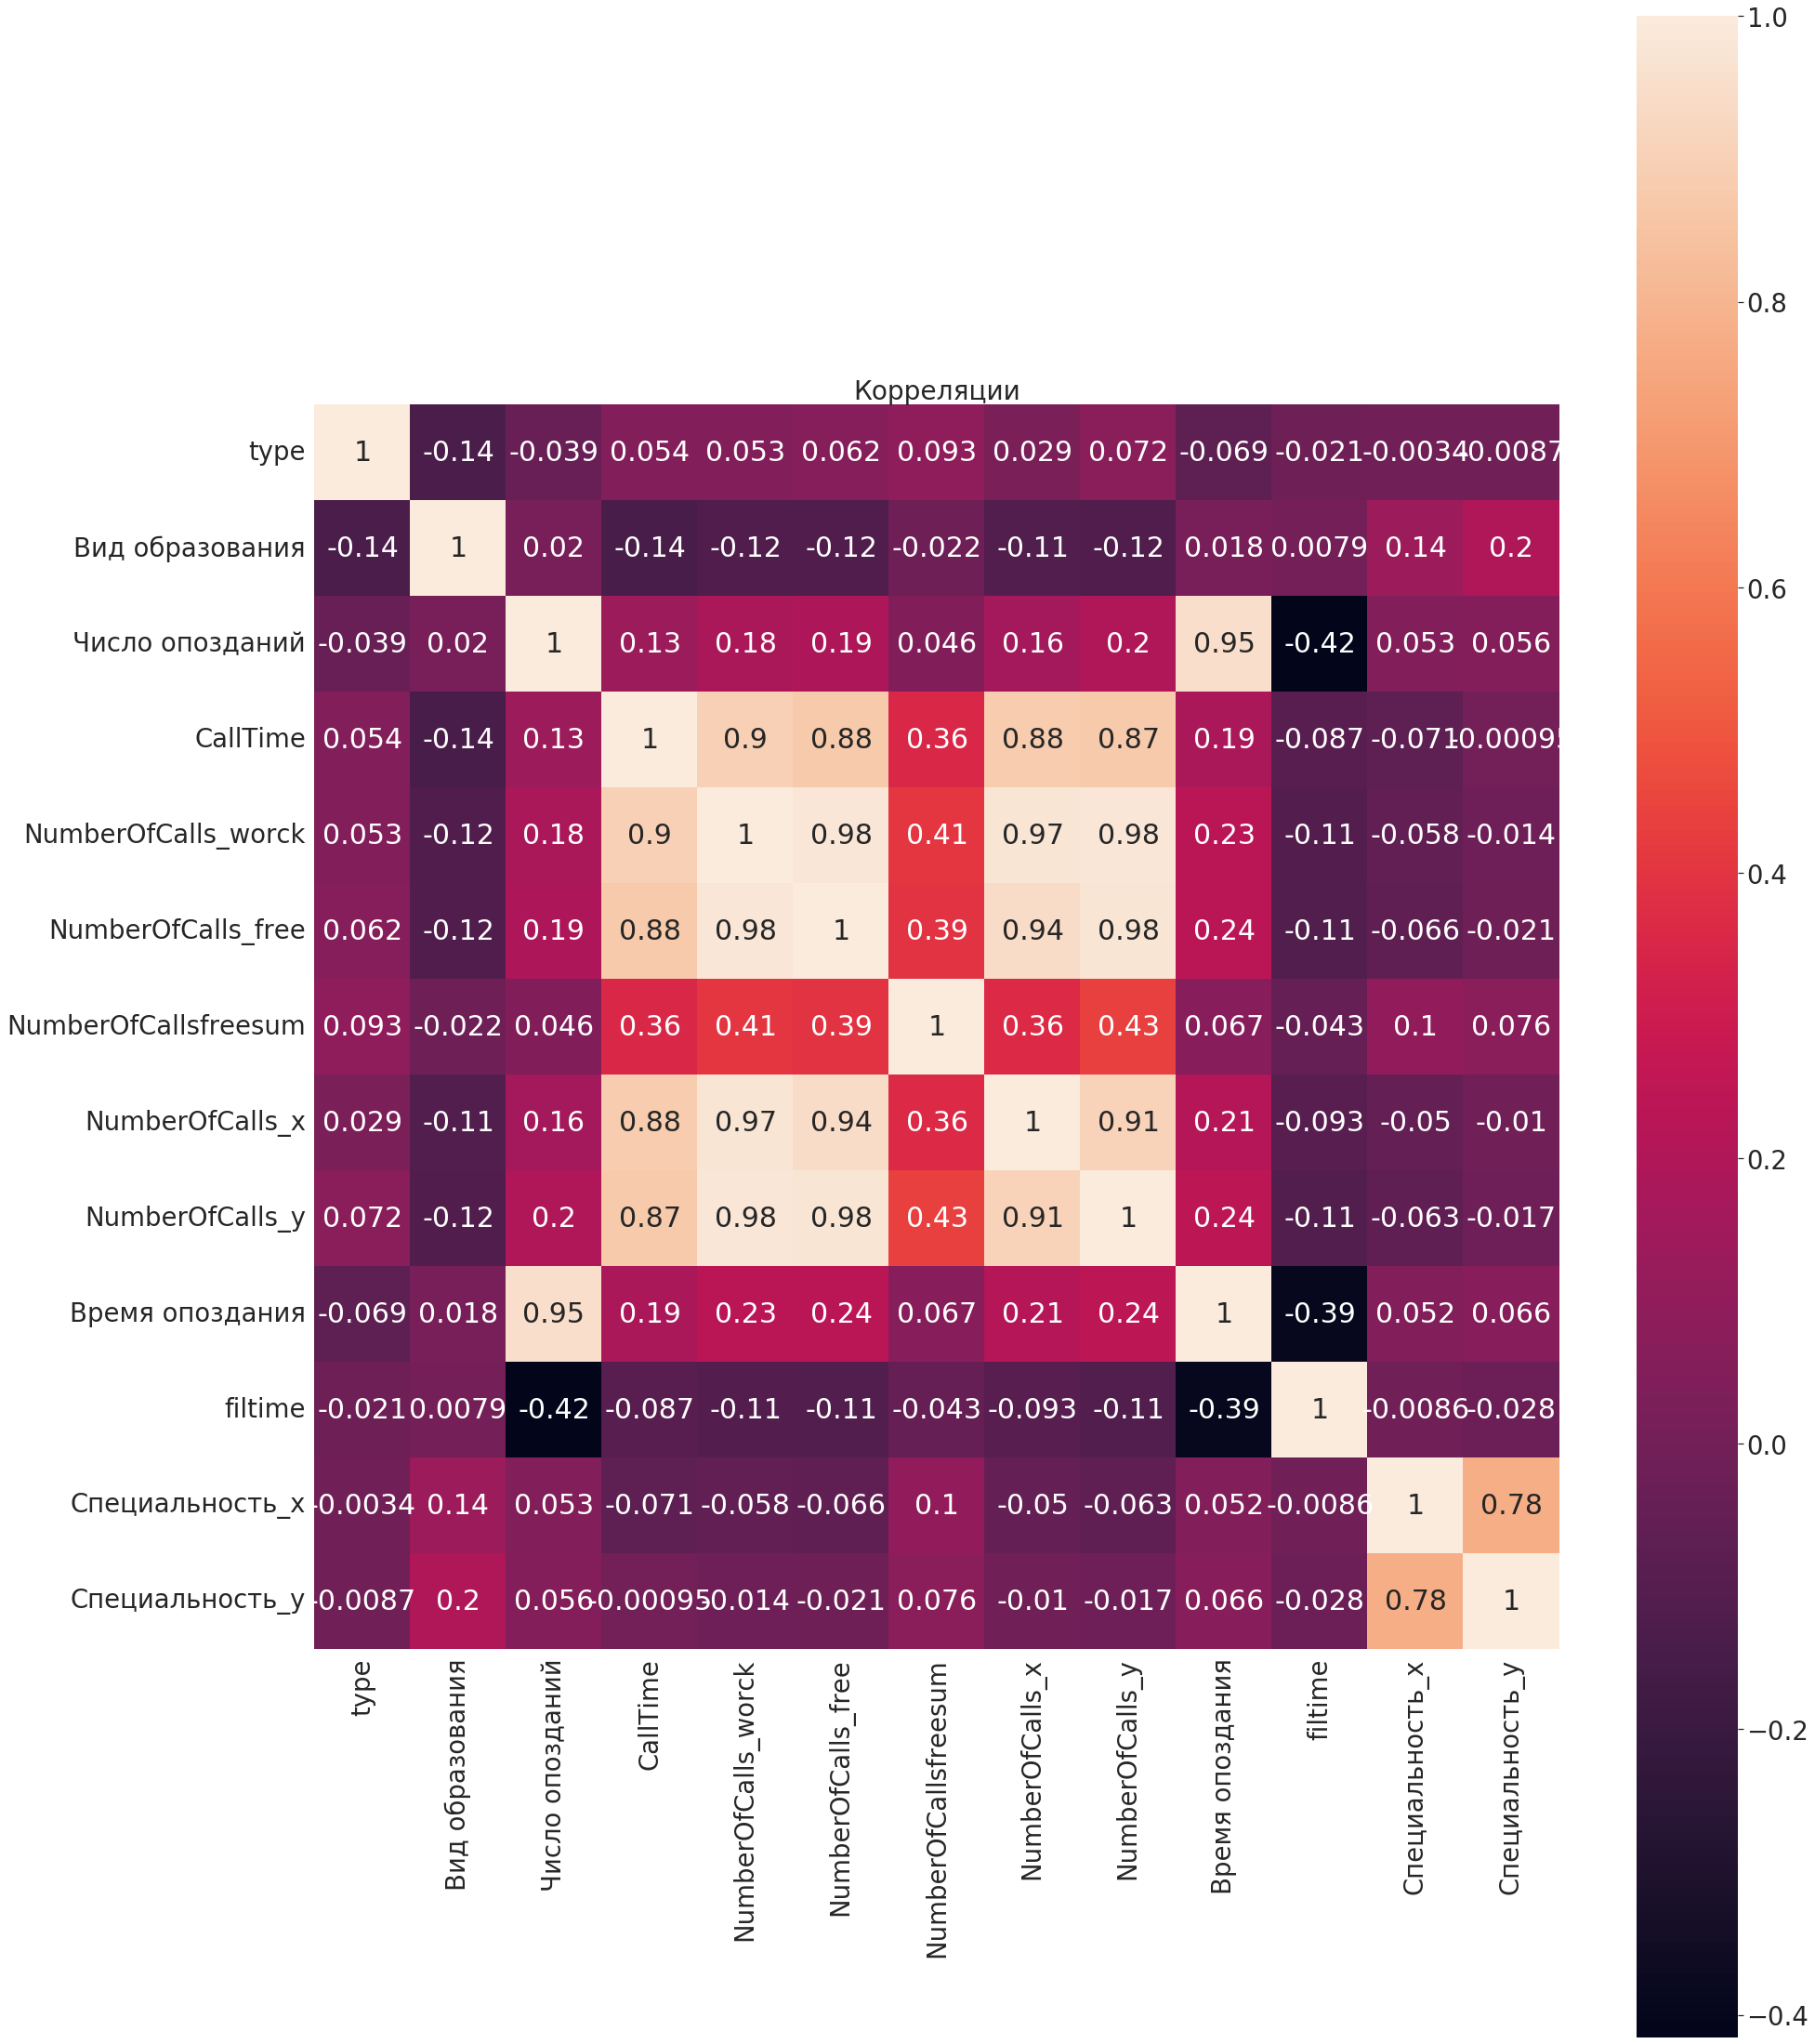

In [67]:
plt.rcParams['figure.figsize']=(30,40)
corr = df_train[df_train.columns[0:14]].corr()
g = sns.heatmap(corr, square = True, annot=True)
plt.title('Корреляции', size=28)
plt.xticks(rotation=90)
plt.show()

## Выделим выборки

In [68]:
X = df_train.drop(['id', 'type',], axis = 1)
y = df_train["type"]

In [69]:
X.shape

(550, 108)

# Стандартизация величин!

In [70]:
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# smote Балансировка датасета.

In [72]:
sm = SMOTE (random_state=0,k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample (X_train,  y_train,) 
X_train,  y_train = X_train_res, y_train_res

# Обучение модели

In [73]:
clf1=OneVsRestClassifier(RandomForestClassifier(max_depth=2,random_state=2))
clf2=OneVsRestClassifier(LogisticRegression(max_iter=500, random_state=2))
clf3=OneVsRestClassifier(GaussianNB(var_smoothing=0.000005))

In [74]:
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('gnb', clf2),('gnbl', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)


In [75]:
X_train.shape

(1032, 108)

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB,    # use any cross validation technique 
                 verbose=1, 
                 scoring='recall_macro') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_


parametrs = {
              'max_depth':range(1,25),
              'min_samples_leaf': range (2,15),
              'min_samples_split': range (2,15,) }
grid = GridSearchCV(RandomForestClassifier(), parametrs, scoring='recall_macro', cv=10,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

gb_grid_params = {'max_depth': range(1,20),
              }

gb_gs = GradientBoostingClassifier(n_estimators = 600)

clf = GridSearchCV(LGBMClassifier(max_depth=3,random_state=2),
                               gb_grid_params,
                               cv=2,
                               scoring='recall_macro',
                               verbose = 3, 
                               n_jobs=-1);
clf.fit(X_train, y_train)
clf.best_params_

for i in range(1,100):
    clf=OneVsRestClassifier(RandomForestClassifier(max_depth= 2,n_estimators=i))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(i,"Recall score:", recall_score(y_test, pred, average='macro'))

for i in range(200,500):
    clf1=OneVsRestClassifier(RandomForestClassifier(max_depth=2, random_state=2))
    clf2=OneVsRestClassifier(LogisticRegression(max_iter=i, random_state=2))
    clf3=OneVsRestClassifier(GaussianNB(var_smoothing=0.000005))
    eclf1 = VotingClassifier(estimators=[('lr', clf1), ('gnb', clf2),('gnbl', clf3)], voting='hard')
    eclf1 = eclf1.fit(X_train, y_train)
    pred = eclf1.predict(X_test)
    print(i,classification_report(y_test, pred))

## Оценка точности

In [76]:
pred = eclf1.predict(X_test)
pred

array([1, 3, 0, 0, 0, 3, 2, 1, 1, 3, 3, 0, 0, 1, 1, 1, 2, 3, 2, 0, 3, 2,
       3, 3, 1, 2, 0, 2, 0, 0, 3, 0, 2, 3, 0, 1, 1, 0, 0, 3, 0, 0, 1, 0,
       1, 2, 1, 1, 2, 3, 1, 1, 2, 1, 0, 0, 1, 0, 1, 3, 0, 1, 1, 1, 1, 0,
       0, 2, 0, 0, 1, 3, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0])

In [77]:
y_test.head(3)

195    2
79     2
480    0
Name: type, dtype: int64

In [78]:

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.4642628205128205


In [79]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.45      0.54      0.49        24
           1       0.29      0.62      0.39        13
           2       0.67      0.20      0.31        40
           3       0.21      0.50      0.30         6

    accuracy                           0.39        83
   macro avg       0.40      0.46      0.37        83
weighted avg       0.51      0.39      0.37        83



## Генерация предсказания

In [80]:
df_test

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0
...,...,...
257,ОРГ1-02893,0
258,ОРГ2-01077,0
259,ОРГ1-00469,0
260,ОРГ1-02060,0


## Добавим фичи.

In [81]:
df_test = pd.merge(df_test, df_ed , on="id", how='left').drop_duplicates(subset="id")
df_test = df_test.drop(["Табельный номер руководителя", "Специальность"],axis = 1)
df_test["Вид образования"] = df_test["Вид образования"].astype('category')
df_test["Вид образования"] = df_test["Вид образования"].cat.codes
df_test = pd.merge(df_test, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

# Добавим суммарное время звоков

In [82]:
df_test = pd.merge(df_test, CallTime , on="id", how='left')

## Добавим колличество звонков в будни и выходные дни

In [83]:
df_test = pd.merge(df_test, NumberOfCalls , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsW , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsNW , on="id", how='left')
df_test = df_test.rename(columns={'NumberOfCalls_x': 'NumberOfCalls_worck','NumberOfCalls_y': 'NumberOfCalls_free','NumberOfCalls': 'NumberOfCallsfreesum'})

## Добавим колличество входящих и исходящих

In [84]:
df_test = pd.merge(df_test, NumberToUser , on="id", how='left')
df_test = pd.merge(df_test, NumberFromUser , on="id", how='left')

# Добавим суммарное время опоздания

In [85]:
df_test = pd.merge(df_test, falout , on="id", how='left')

# Добавим дельту прихода на работу

In [86]:
df_test  = pd.merge(df_test, filtime , on="id", how='left')

# Добавим профессию

In [87]:
profession=df_ed[['id','Специальность']].groupby('id')['Специальность'].min()
df_test = pd.merge(df_test, professionstart , on="id", how='left')
df_test = pd.merge(df_test, professionend , on="id", how='left')

In [88]:
df_test.head()

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y
0,ОРГ1-02649,0,-1,NaN,1.045278e+17,4.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,ОРГ2-05929,0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN,9.550722e+17,-1057.019584,999.0,999.0
2,ОРГ2-05859,0,8,104.0,NaN,NaN,NaN,NaN,NaN,NaN,5.190126e+18,-2103.577020,NaN,NaN
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,5.900416e+17,-570.718116,4.0,4.0
4,ОРГ2-01613,0,2,17.0,NaN,NaN,NaN,NaN,NaN,NaN,1.839148e+18,-386.013125,4.0,4.0


## Добавим колличество руководителей

In [89]:
df_test = pd.merge(df_test, boss , on="id", how='left')

# Добавим колличество завершенных заданий.

In [90]:
df_test = pd.merge(df_test,status_mission_count, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_in, on="id", how='left')
for i in range(1,13):
    tasks_month_sum_start=pd.DataFrame(df_tasks.query("status_mission_count=='В работе'").query('month==@i').groupby('id')['Дата старта задания'].nunique()).rename(columns={'Дата старта задания': 'tasks_month_sum_start'+ str(i)})
    df_test = pd.merge(df_test,tasks_month_sum_start, on="id", how='left')
for i in range(1,13):
    tasks_month_sum_end=pd.DataFrame(df_tasks.query("status_mission_count=='Завершено'").query('monthstart==@i').groupby('id')['Дата старта задания'].nunique()).rename(columns={'Дата старта задания': 'tasks_month_sum_end'+ str(i)})
    df_test = pd.merge(df_test,tasks_month_sum_end, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_nn, on="id", how='left')
for i in range(1,13):
    tasks_month_sum_startn=pd.DataFrame(df_tasks.query("status_mission_count=='Делегировано'").query('monthstart==@i').groupby('id')['Дата старта задания'].nunique()).rename(columns={'Дата старта задания': 'tasks_month_sum_startn'+ str(i)})
    df_test = pd.merge(df_test,tasks_month_sum_startn, on="id", how='left')
df_train
df_test = pd.merge(df_test,status_mission_count_d, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_p, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_o, on="id", how='left')

# Добавим сумму просроченных дней

In [91]:
df_test = pd.merge(df_test,day_ful_mission, on="id", how='left')

# Добавим статус по просрочке с нарушением без науршения и их отношение.

In [92]:
df_test = pd.merge(df_test,fail_count_b, on="id", how='left')
df_test = pd.merge(df_test,fail_count_p, on="id", how='left')
df_test['bp']=df_test['статус_просрочек']/df_test['просрочено']

# Добавим общее время активности в сети.

In [93]:
df_test = pd.merge(df_test,timennetwork_time, on="id", how='left')

# Добавим среднее время простоя монитора 

In [94]:
df_test = pd.merge(df_test,monitor_stop, on="id", how='left')

# Добавим счетчик начала рабочего дня

In [95]:
df_test = pd.merge(df_test,start_day, on="id", how='left')

## Добавим колличество уникальных специальностей

In [96]:
df_test = pd.merge(df_test,prof_countis, on="id", how='left')

# Добавим оборотные виды документов

In [97]:
df_test = pd.merge(df_test,documents, on="id", how='left')

# Добавим месяцы звонков

In [98]:
df_test = pd.merge(df_test,monday_calls, on="id", how='left')

# Добавим месяцы в сети

In [99]:
df_test = pd.merge(df_test,monday_worck, on="id", how='left')

# Добавим месяцы активности за монитором

In [100]:
df_test = pd.merge(df_test,monday_Work, on="id", how='left')

# Добавим дельту дат звонка

In [101]:
df_test = pd.merge(df_test,last_cals, on="id", how='left')

# Добавим дельту сети

In [102]:
df_test = pd.merge(df_test,last_net, on="id", how='left')

# Добавим дельту работы за компьютером

In [103]:
df_test = pd.merge(df_test,last_worck, on="id", how='left')

# Звонки по месяцам

In [104]:
for i in range(1,13):
    calls_month_sum=pd.DataFrame(df_calls.query('monday==@i').groupby('id')['CallTime'].mean()).rename(columns={'CallTime': 'calls_month_sum'+ str(i)})
    df_test = pd.merge(df_test,calls_month_sum, on="id", how='left')
df_test

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,calls_month_sum3,calls_month_sum4,calls_month_sum5,calls_month_sum6,calls_month_sum7,calls_month_sum8,calls_month_sum9,calls_month_sum10,calls_month_sum11,calls_month_sum12
0,ОРГ1-02649,0,-1,NaN,1.045278e+17,4.0,4.0,NaN,NaN,4.0,...,NaN,NaN,1.111111e+16,NaN,NaN,4.670833e+16,NaN,NaN,NaN,NaN
1,ОРГ2-05929,0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-05859,0,8,104.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,...,3.386546e+16,3.300323e+16,3.982333e+16,3.701212e+16,3.809171e+16,3.818047e+16,3.500966e+16,3.284738e+16,3.194812e+16,3.435212e+16
4,ОРГ2-01613,0,2,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,ОРГ1-02893,0,9,117.0,1.244414e+19,1404.0,1357.0,47.0,875.0,529.0,...,3.282815e+16,2.996409e+16,2.867974e+16,3.713215e+16,3.758858e+16,3.170899e+16,3.192381e+16,2.319802e+16,3.732975e+16,3.046705e+16
258,ОРГ2-01077,0,2,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,ОРГ1-00469,0,0,2.0,2.311854e+19,5103.0,5103.0,NaN,2646.0,2457.0,...,3.098769e+16,2.554089e+16,3.274976e+16,3.185881e+16,3.227891e+16,2.671758e+16,2.590934e+16,3.108329e+16,2.790203e+16,3.075280e+16
260,ОРГ1-02060,0,0,1.0,1.104076e+19,1251.0,1248.0,3.0,528.0,723.0,...,3.356172e+16,3.312634e+16,4.064957e+16,3.326481e+16,3.724415e+16,1.830957e+16,2.917697e+16,3.776524e+16,2.881481e+16,2.749747e+16


# Даты окончаний заданий по месяцам.

In [105]:
for i in range(1,13):
    tasks_month_sum=pd.DataFrame(df_tasks.query('month==@i').groupby('id')['Просрочено, дней'].sum()).rename(columns={'Просрочено, дней': 'tasks_month_sum'+ str(i)})
    df_test = pd.merge(df_test,tasks_month_sum, on="id", how='left')
df_test

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum3,tasks_month_sum4,tasks_month_sum5,tasks_month_sum6,tasks_month_sum7,tasks_month_sum8,tasks_month_sum9,tasks_month_sum10,tasks_month_sum11,tasks_month_sum12
0,ОРГ1-02649,0,-1,NaN,1.045278e+17,4.0,4.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ОРГ2-05929,0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-05859,0,8,104.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2565.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,...,3.0,5.0,38.0,15.0,8.0,5.0,13.0,48.0,7.0,5.0
4,ОРГ2-01613,0,2,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,ОРГ1-02893,0,9,117.0,1.244414e+19,1404.0,1357.0,47.0,875.0,529.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0
258,ОРГ2-01077,0,2,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
259,ОРГ1-00469,0,0,2.0,2.311854e+19,5103.0,5103.0,NaN,2646.0,2457.0,...,5.0,7.0,0.0,112.0,46.0,91.0,157.0,380.0,56.0,0.0
260,ОРГ1-02060,0,0,1.0,1.104076e+19,1251.0,1248.0,3.0,528.0,723.0,...,2.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,245.0,NaN


# Добавим сеть по месяцам

In [106]:
for i in range(6,13):
    net_month_sum=pd.DataFrame(timennetwork.query('mondayW==@i').groupby('id')['monitor_Time'].mean()).rename(columns={'monitor_Time': 'net_month_sum'+ str(i)})
    df_test = pd.merge(df_test,net_month_sum, on="id", how='left')
df_test

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,tasks_month_sum10,tasks_month_sum11,tasks_month_sum12,net_month_sum6,net_month_sum7,net_month_sum8,net_month_sum9,net_month_sum10,net_month_sum11,net_month_sum12
0,ОРГ1-02649,0,-1,NaN,1.045278e+17,4.0,4.0,NaN,NaN,4.0,...,NaN,NaN,NaN,23039.125000,18951.307692,23658.565217,18559.615385,NaN,NaN,NaN
1,ОРГ2-05929,0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,300.250000,300.000000,14775.444444,17992.368421,18309.421053,21912.666667,5187.904762
2,ОРГ2-05859,0,8,104.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16503.000000,18362.269231,19760.806452,18359.240000,17358.630435,11999.166667,8815.651163
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,...,48.0,7.0,5.0,34889.625000,21743.166667,28006.181818,29322.555556,29767.066667,26163.333333,29003.521739
4,ОРГ2-01613,0,2,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,219.0,15080.625000,15420.714286,17705.590909,15740.863636,20497.150000,14616.050000,8895.590909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,ОРГ1-02893,0,9,117.0,1.244414e+19,1404.0,1357.0,47.0,875.0,529.0,...,NaN,NaN,0.0,NaN,NaN,12571.764706,11973.795455,17514.034483,14186.219512,13552.813953
258,ОРГ2-01077,0,2,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,16667.727273,15101.607143,11786.068966,10642.964286,15515.666667,19912.714286,14559.000000
259,ОРГ1-00469,0,0,2.0,2.311854e+19,5103.0,5103.0,NaN,2646.0,2457.0,...,380.0,56.0,0.0,32940.500000,34667.333333,34291.523810,29995.846154,29274.250000,29712.000000,32043.666667
260,ОРГ1-02060,0,0,1.0,1.104076e+19,1251.0,1248.0,3.0,528.0,723.0,...,0.0,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10055.750000


# Добавим работу за компьютером по месяцам

In [107]:
for i in range(6,13):
    worck_month_sum=pd.DataFrame(workingday.query('mondayWork==@i').groupby('id')['monitorTime'].mean()).rename(columns={'monitorTime': 'worck_month_sum'+ str(i)})
    df_test = pd.merge(df_test,worck_month_sum, on="id", how='left')
df_test

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,net_month_sum10,net_month_sum11,net_month_sum12,worck_month_sum6,worck_month_sum7,worck_month_sum8,worck_month_sum9,worck_month_sum10,worck_month_sum11,worck_month_sum12
0,ОРГ1-02649,0,-1,NaN,1.045278e+17,4.0,4.0,NaN,NaN,4.0,...,NaN,NaN,NaN,9065.618557,15852.409639,8290.234875,7709.815217,NaN,NaN,NaN
1,ОРГ2-05929,0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,18309.421053,21912.666667,5187.904762,58.200000,62.000000,5923.168750,3588.557971,2485.878378,2980.915033,1508.000000
2,ОРГ2-05859,0,8,104.0,NaN,NaN,NaN,NaN,NaN,NaN,...,17358.630435,11999.166667,8815.651163,3803.910448,2749.395257,2351.438596,3323.394464,2870.934066,2149.024896,1689.508475
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,...,29767.066667,26163.333333,29003.521739,3187.377483,4565.460993,3237.986079,4869.879479,5286.943478,2735.117143,5260.541284
4,ОРГ2-01613,0,2,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,20497.150000,14616.050000,8895.590909,6064.466667,11821.115152,7728.605000,6550.706250,9202.790576,3359.724868,1187.278027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,ОРГ1-02893,0,9,117.0,1.244414e+19,1404.0,1357.0,47.0,875.0,529.0,...,17514.034483,14186.219512,13552.813953,NaN,NaN,1598.797386,1886.685811,2624.675676,1971.746622,1937.396774
258,ОРГ2-01077,0,2,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15515.666667,19912.714286,14559.000000,10058.373626,10985.681416,12787.261538,9585.645161,9855.423077,8846.962121,9017.646853
259,ОРГ1-00469,0,0,2.0,2.311854e+19,5103.0,5103.0,NaN,2646.0,2457.0,...,29274.250000,29712.000000,32043.666667,8419.259615,14477.703297,7924.920266,7729.729885,9128.326389,8054.117450,7468.805112
260,ОРГ1-02060,0,0,1.0,1.104076e+19,1251.0,1248.0,3.0,528.0,723.0,...,NaN,NaN,10055.750000,NaN,NaN,NaN,NaN,NaN,NaN,2632.567164


# Удалим пустые значения

In [108]:
df_test = df_test.fillna(0)

In [109]:
df_test

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,net_month_sum10,net_month_sum11,net_month_sum12,worck_month_sum6,worck_month_sum7,worck_month_sum8,worck_month_sum9,worck_month_sum10,worck_month_sum11,worck_month_sum12
0,ОРГ1-02649,0,-1,0.0,1.045278e+17,4.0,4.0,0.0,0.0,4.0,...,0.000000,0.000000,0.000000,9065.618557,15852.409639,8290.234875,7709.815217,0.000000,0.000000,0.000000
1,ОРГ2-05929,0,1,19.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,18309.421053,21912.666667,5187.904762,58.200000,62.000000,5923.168750,3588.557971,2485.878378,2980.915033,1508.000000
2,ОРГ2-05859,0,8,104.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,17358.630435,11999.166667,8815.651163,3803.910448,2749.395257,2351.438596,3323.394464,2870.934066,2149.024896,1689.508475
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,...,29767.066667,26163.333333,29003.521739,3187.377483,4565.460993,3237.986079,4869.879479,5286.943478,2735.117143,5260.541284
4,ОРГ2-01613,0,2,17.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,20497.150000,14616.050000,8895.590909,6064.466667,11821.115152,7728.605000,6550.706250,9202.790576,3359.724868,1187.278027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,ОРГ1-02893,0,9,117.0,1.244414e+19,1404.0,1357.0,47.0,875.0,529.0,...,17514.034483,14186.219512,13552.813953,0.000000,0.000000,1598.797386,1886.685811,2624.675676,1971.746622,1937.396774
258,ОРГ2-01077,0,2,29.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,15515.666667,19912.714286,14559.000000,10058.373626,10985.681416,12787.261538,9585.645161,9855.423077,8846.962121,9017.646853
259,ОРГ1-00469,0,0,2.0,2.311854e+19,5103.0,5103.0,0.0,2646.0,2457.0,...,29274.250000,29712.000000,32043.666667,8419.259615,14477.703297,7924.920266,7729.729885,9128.326389,8054.117450,7468.805112
260,ОРГ1-02060,0,0,1.0,1.104076e+19,1251.0,1248.0,3.0,528.0,723.0,...,0.000000,0.000000,10055.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2632.567164


## Предсказания

In [110]:
df_test_pred = pd.read_csv("test.csv")
Xpred = df_test.drop(['id', 'type'], axis = 1)
Xpred=scaler.transform(Xpred)
preds = eclf1.predict(Xpred)
df_test_pred['type']=preds

In [111]:
df_test_pred.to_csv('bestmodel2.csv', index=False)

In [112]:
df_test_pred['type'].value_counts()

0    87
1    78
3    51
2    46
Name: type, dtype: int64